In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv


<h2>Project Scope</h2>
     <ul>
            <li>Using solar generation and associated temperature data to explore time series forecasting.</li>
            <li>Examine outliers and missing data</li>
            <li>Compare the performance of ML models and a deep learning LSTM model to make a day-ahead forecast of power generation</li>
            <li>See what impact including the temperature data has on the forecast</li>
            <li>Experiment with feature engineering and test the impact differernt features have on the models</li>
            <li>Fine tune the models</li>
            <li>Report on what model is ultimately more successful and comment on possible project extensions</li>
    </ul>


<h2>Loading and exploring data</h2>
This data was taken from two solar plants in India over the course of 34 days in 15 minute intervals. The weather data is on the plant level (just measured from one sensor) and the generation data is gathered from individual inverters across the plant. More information can be found here: 
<a href="https://www.kaggle.com/datasets/anikannal/solar-power-generation-data">Data Card</a>. Credit to 
<a href="https://www.kaggle.com/anikannal">Ani Kannal</a> for uploading this dataset to Kaggle.


In [2]:
df_plt1_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
df_plt2_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')
df_plt1_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
df_plt2_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

df_plt1_gen.sample(10, random_state=1)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
32384,31-05-2020 15:30,4135001,pkci93gMrogZuBj,3142.571429,308.771429,5405.285714,7294281.286
58525,13-06-2020 02:45,4135001,zVJPv84UY57bAof,0.000000,0.000000,0.000000,7328550.000
26110,28-05-2020 07:45,4135001,McdE0feGgRqW7Ca,4259.857143,418.400000,308.142857,7256697.143
17618,24-05-2020 05:30,4135001,WRmjgnKYAwPKWDb,0.000000,0.000000,0.000000,7093026.000
3631,16-05-2020 21:00,4135001,YxYtjZvoooNbGkE,0.000000,0.000000,6475.000000,7192732.000
39654,04-06-2020 02:45,4135001,WRmjgnKYAwPKWDb,0.000000,0.000000,0.000000,7174627.000
22786,26-05-2020 16:45,4135001,iCRJl6heRkivqQ3,6204.142857,607.871429,7617.571429,7267747.571
43162,05-06-2020 19:30,4135001,zBIq5rxdHJRwDNY,0.000000,0.000000,7723.000000,6500302.000
11802,21-05-2020 08:00,4135001,WRmjgnKYAwPKWDb,5096.400000,499.640000,405.000000,7070130.000
52279,10-06-2020 04:00,4135001,1IF53ai7Xc0U56Y,0.000000,0.000000,0.000000,6380022.000


PLANT_ID is the same throughout, so it can be safely removed. The generation is 0 for nighttime, which of course makes sense for solar power. Also, let's rename to sources to make them easier to track

In [3]:
df_gen = df_plt1_gen.drop('PLANT_ID', axis=1)
df_gen['SOURCE_KEY'] = df_gen.SOURCE_KEY.map({df_gen.SOURCE_KEY.unique()[i-1]: f'Source_{i}' for i in range(1, len(df_gen.SOURCE_KEY.unique()) +1)})
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), object(2)
memory usage: 3.1+ MB


In [4]:
df_gen.SOURCE_KEY

0         Source_1
1         Source_2
2         Source_3
3         Source_4
4         Source_5
           ...    
68773    Source_17
68774    Source_18
68775    Source_19
68776    Source_20
68777    Source_21
Name: SOURCE_KEY, Length: 68778, dtype: object

The dtypes make sense, but we'll need to make the DATE_TIME a datetime object for easier analysis. No nulls detected here, but there still could be outliers or nulls encoded in a different way.

In [5]:
df_gen['DATE_TIME'] = pd.to_datetime(df_gen.DATE_TIME, format='%d-%m-%Y %H:%M')
df_gen.dtypes

DATE_TIME      datetime64[ns]
SOURCE_KEY             object
DC_POWER              float64
AC_POWER              float64
DAILY_YIELD           float64
TOTAL_YIELD           float64
dtype: object

Now we can make some additional features out of the datetime object to aid in our analysis. If we were modeling throughout the year(s), month and year could be interesting to account for seasonal variation and long-term trends, but since our data only covers 34 days, we will omit them. We can use dayofyear to capture any longer trends that might be present.

In [6]:
df_gen['HOUR'] = df_gen.DATE_TIME.dt.hour
df_gen['DAY'] = df_gen.DATE_TIME.dt.dayofyear
df_gen['DAY_WEEK'] = df_gen.DATE_TIME.dt.dayofweek
df_gen['MINUTES_15'] = df_gen.DATE_TIME.dt.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df_gen['MINUTES_15'] = df_gen.MINUTES_15.map({df_gen.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df_gen['DAY'] = df_gen.DAY.map({df_gen.DAY.unique()[i-1]:i for i in range(1, 35)})

Next, let's check on the linear correlation of features.

In [7]:
corr = df_gen.corr(numeric_only=True)
corr

,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR,DAY,DAY_WEEK,MINUTES_15
DC_POWER,1.000000,0.999996,0.082284,0.003815,0.024104,-0.030539,0.017649,0.024131
AC_POWER,0.999996,1.000000,0.082234,0.003804,0.024101,-0.030471,0.017640,0.024127
DAILY_YIELD,0.082284,0.082234,1.000000,0.009867,0.836124,-0.003013,0.027167,0.836208
TOTAL_YIELD,0.003815,0.003804,0.009867,1.000000,0.004988,0.172868,-0.018183,0.004991
HOUR,0.024104,0.024101,0.836124,0.004988,1.000000,-0.008660,0.009823,0.999171
DAY,-0.030539,-0.030471,-0.003013,0.172868,-0.008660,1.000000,-0.103959,-0.008634
DAY_WEEK,0.017649,0.017640,0.027167,-0.018183,0.009823,-0.103959,1.000000,0.009812
MINUTES_15,0.024131,0.024127,0.836208,0.004991,0.999171,-0.008634,0.009812,1.000000


And why not make it a heatmap

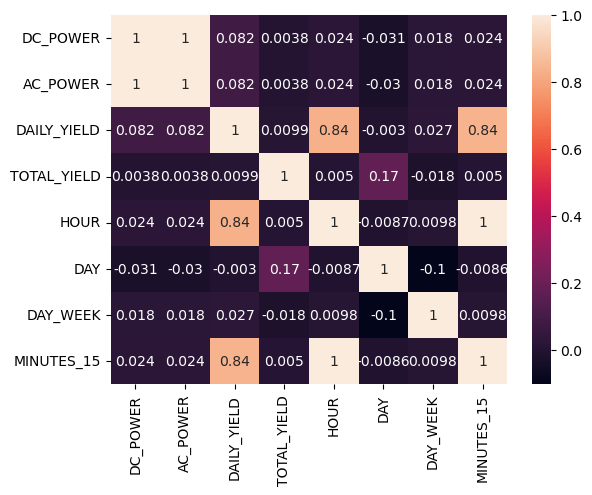

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Spectral')

sns.heatmap(corr, annot=True);

Not surprisingly DC and AC power are highly correlated. This is good! It probably means the inverters in the plant are working correctly to convert the DC to AC. We will ultimately make AC_POWER our target and are probably safe to remove DC_POWER at this point. There is a strong correlation between HOUR and DAILY_YIELD, which makes sense as the daily yield increases throughout the day. Now we will look at a pairplot to see another representation of these relationships and look for any non-linear correlations.

In [9]:
df_gen = df_gen.drop('DC_POWER', axis=1)

In [10]:
# g = sns.PairGrid(df_gen.sample(5000), diag_sharey=False, hue='SOURCE_KEY')
# g.map_upper(sns.scatterplot, s=15)
# g.map_lower(sns.kdeplot)
# g.map_diag(sns.histplot)
# #This takes quite a while to run, so saving this figure for future use.
# plt.savefig("gen_pairgrid.png", dpi=400)

In [11]:
# from IPython.display import Image, display
# display(Image(filename='/kaggle/working/gen_pairgrid.png'))

There is A LOT of information to take in here! The zeros dominate the distribution for AC_POWER and DAILY_YIELD due to the nighttime. It looks like some data is missing based on the DAY/MINUTES pair. The inverters start to seperate out based on TOTAL_YIELD and DAILY_YIELD. This suggests the they are operating a different capacities; probably due to any number of factors: age, location within the plant, need for maintaince, etc. Exploring this more is outside the scope of this project, but could be a good starting point for another project. Finally, the connection between HOUR and AC_POWER is interesting and also makes sense with the peaks in the middle of the day. Let's explore this more next and also start to look for outliers.

## Outliers

## Target outliers

To explore outliers let's start by defining an outlier as \< 1th percentile or \> 99th percentile. To do this I will make four quantile features below: 2 of them in the outlier range and 2 to establish 1 standard deviation from the mean. Then we can plot the results. Let's also get the mean while we're at it.

In [12]:
df_gen = df_gen.merge(df_gen.groupby('MINUTES_15').quantile(0.01, numeric_only=True).AC_POWER.rename('OUTLIERS_LOW_AC_POWER'), on='MINUTES_15', how='left')
df_gen = df_gen.merge(df_gen.groupby('MINUTES_15').quantile(0.99, numeric_only=True).AC_POWER.rename('OUTLIERS_HIGH_AC_POWER'), on='MINUTES_15', how='left')
df_gen = df_gen.merge(df_gen.groupby('MINUTES_15').mean(numeric_only=True).AC_POWER.rename('MEAN'), on='MINUTES_15', how='left')
df_gen = df_gen.merge(df_gen.groupby('MINUTES_15').std(numeric_only=True).AC_POWER.rename('STD'), on='MINUTES_15', how='left')
df_gen['STD_1'] = df_gen.query('AC_POWER < (MEAN + STD) and AC_POWER > (MEAN - STD)').AC_POWER

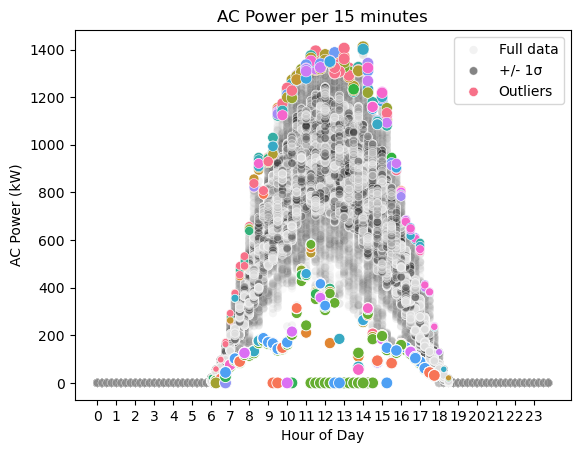

In [13]:
fig, ax = plt.subplots()
sns.color_palette("Paired")
sns.scatterplot(data=df_gen, y='AC_POWER', x='MINUTES_15', hue='SOURCE_KEY', palette='gray', alpha=0.05, legend=False)
sns.scatterplot(data=df_gen, y='STD_1', x='MINUTES_15', hue='SOURCE_KEY', palette='gray', alpha =0.5, legend=False)
sns.scatterplot(data=df_gen.query('AC_POWER > OUTLIERS_HIGH_AC_POWER'), y='AC_POWER', x='MINUTES_15', hue='SOURCE_KEY', size='AC_POWER')
sns.scatterplot(data=df_gen.query('AC_POWER < OUTLIERS_LOW_AC_POWER'), y='AC_POWER', x='MINUTES_15', hue='SOURCE_KEY', size= -df_gen.AC_POWER) 

plt.title('AC Power per 15 minutes')
plt.ylabel('AC Power (kW)')
plt.xlabel('Hour of Day')
ax.set_xticks([i for i in range(1, 97, 4)])
ax.set_xticklabels([i for i in range(24)])
ax.legend(['Full data', '+/- 1\u03C3', 'Outliers']);

Interestingly, it looks like there are several instances where the power generated during the middle of the day was 0. This could either indicate bad data, malfunctioning invererters, some kind of planned maintence, really cloudy days, really sunny days where the plant is overheating/at capacity or any number of other things. Without having a deeper domain knowledge it is hard to know for sure, but let's see if we can find any pattern to these mid-day outliers.


First, we'll check to see if any inverters in particular are responsible.

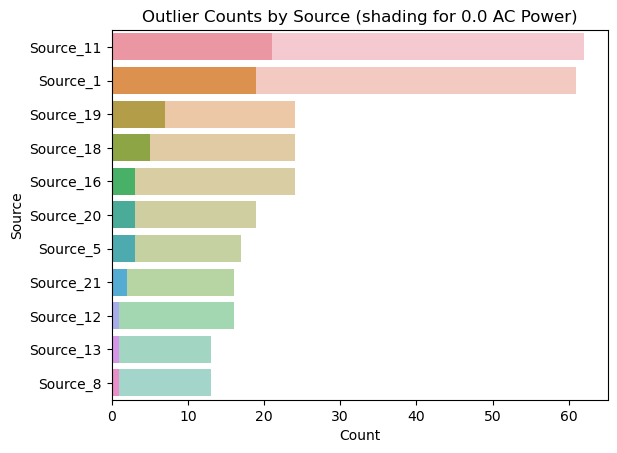

In [14]:
outliers_low = df_gen.query('AC_POWER < OUTLIERS_LOW_AC_POWER')
outliers_high = df_gen.query('AC_POWER > OUTLIERS_HIGH_AC_POWER')

outliers_source_low = outliers_low.groupby('SOURCE_KEY').count().DATE_TIME.reset_index().sort_values('DATE_TIME', ascending=False)
outliers_source_low_zero = outliers_low[outliers_low.AC_POWER == 0].groupby('SOURCE_KEY').count().DATE_TIME.reset_index().sort_values('DATE_TIME', ascending=False)
fig, ax = plt.subplots()
sns.barplot(data = outliers_source_low, y='SOURCE_KEY', x='DATE_TIME', alpha = 0.5, )
sns.barplot(data = outliers_source_low_zero, y='SOURCE_KEY', x='DATE_TIME')
plt.title('Outlier Counts by Source (shading for 0.0 AC Power)')
plt.ylabel('Source')
plt.xlabel('Count');

The spread of outlier counts, including the 0.0 AC_POWER measurements are concentrated in sources 11 and 1. It could be that these were offline for an extended period due to maintance or malfunction. Below we'll look at the spread of the outliers over the course of the full 34 days to see if there is any regularity.

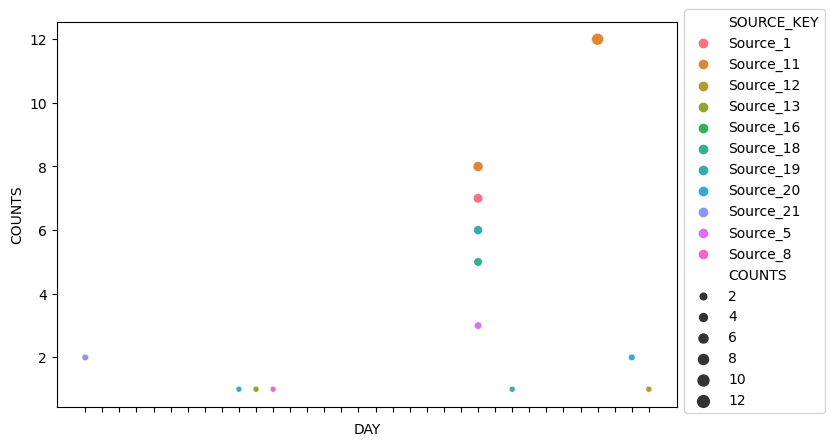

In [15]:
outliers_zero_count = outliers_low[outliers_low.AC_POWER == 0].groupby(['SOURCE_KEY','DAY']).count().rename(columns={'AC_POWER':'COUNTS'}).COUNTS.reset_index()
outliers_zero_count
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=outliers_zero_count, x='DAY', y='COUNTS', hue='SOURCE_KEY', size='COUNTS', legend='brief')
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_xticks([i for i in range(1,35)]);
ax.set_xticklabels([]);


Several occur on the same day. There could have been maintance that day or another issue.

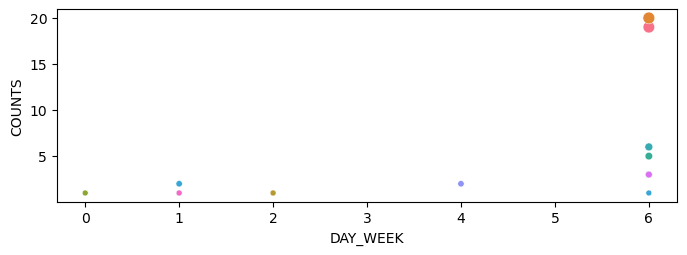

In [16]:
outliers_zero_count = outliers_low[outliers_low.AC_POWER == 0].groupby(['SOURCE_KEY','DAY_WEEK']).count().rename(columns={'AC_POWER':'COUNTS'}).COUNTS.reset_index()
outliers_zero_count
fig, ax = plt.subplots(figsize=(8,2.5))
sns.scatterplot(data=outliers_zero_count, x='DAY_WEEK', y='COUNTS', hue='SOURCE_KEY', size='COUNTS', legend=False);
# ax.legend(label='Sources', loc='upper left')


Interestingly, several of the zeros occur on Sunday. This could still be coincidence or it might suggest some scheduled maintance, since Sunday is likely a day with less demand on the grid and it would make sense to choose that as a day for maintance. Let's circle back and check on non-zero outliers as well.

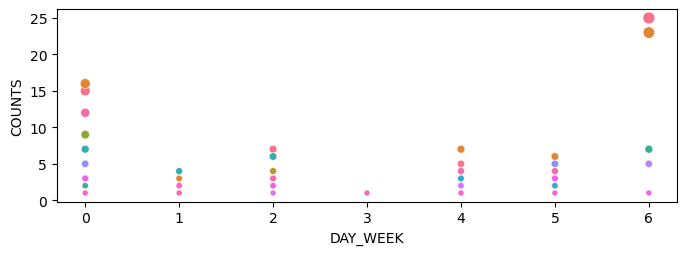

In [17]:
outliers_low_count = outliers_low.groupby(['SOURCE_KEY','DAY_WEEK']).count().rename(columns={'AC_POWER':'COUNTS'}).COUNTS.reset_index()
fig, ax = plt.subplots(figsize=(8,2.5))
sns.scatterplot(data=outliers_low_count, x='DAY_WEEK', y='COUNTS', hue='SOURCE_KEY', size='COUNTS', legend=False);

There is a greater number of overall outliers on Monday. We might guess that after Sunday maintance there is a delay getting everything back online that goes into Monday. I think there is enough evidence now to choose to keep these outliers in our data as it might help the model account for some of this. That being said the number is low enough that it likely won't have too much of an impact.

The outliers representing the 99th percentile are not as much of a concern, as they seem well connected to the distribution and likely just indicate extra sunny/hot days. We can check this assumption by seeing how they lineup with the weather data. First, we'll load and take a quick look at the weather data.

## Loading weather data

In [18]:
df_weather = df_plt1_weather
df_weather.sample(10, random_state=1)

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
1194,2020-05-28 02:30:00,4135001,HmiyD2TTLFNqkNe,22.398088,20.536780,0.000000
2385,2020-06-09 16:45:00,4135001,HmiyD2TTLFNqkNe,29.618705,37.964126,0.302090
99,2020-05-16 03:30:00,4135001,HmiyD2TTLFNqkNe,21.731421,20.351884,0.000000
2779,2020-06-13 19:15:00,4135001,HmiyD2TTLFNqkNe,24.000767,21.948254,0.000000
13,2020-05-15 03:15:00,4135001,HmiyD2TTLFNqkNe,24.985215,24.351508,0.000000
2304,2020-06-08 20:30:00,4135001,HmiyD2TTLFNqkNe,24.091545,20.824284,0.000000
442,2020-05-19 18:00:00,4135001,HmiyD2TTLFNqkNe,25.046377,25.426198,0.001575
2847,2020-06-14 12:15:00,4135001,HmiyD2TTLFNqkNe,24.932560,36.606858,0.472765
45,2020-05-15 11:15:00,4135001,HmiyD2TTLFNqkNe,30.216062,50.006989,0.585787
705,2020-05-22 22:45:00,4135001,HmiyD2TTLFNqkNe,23.214526,21.719092,0.000000


In [19]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [20]:
df_weather.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DATE_TIME,3182,3182,2020-05-15 00:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLANT_ID,3182.0,NaN,NaN,NaN,4135001.0,0.0,4135001.0,4135001.0,4135001.0,4135001.0,4135001.0
SOURCE_KEY,3182,1,HmiyD2TTLFNqkNe,3182,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMBIENT_TEMPERATURE,3182.0,NaN,NaN,NaN,25.531606,3.354856,20.398505,22.705182,24.613814,27.920532,35.252486
MODULE_TEMPERATURE,3182.0,NaN,NaN,NaN,31.091015,12.261222,18.140415,21.090553,24.61806,41.30784,65.545714
IRRADIATION,3182.0,NaN,NaN,NaN,0.228313,0.300836,0.0,0.0,0.024653,0.449588,1.221652


The weather data looks pretty clean. We can remove the PLANT_ID and SOURCE_KEY, since they are the same throughout (as a reminder the weather data is only measured from a single source). Again, we should make the DATE_TIME a datetime object.

In [21]:
df_weather = df_weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_weather['DATE_TIME'] = pd.to_datetime(df_weather.DATE_TIME, format='%Y-%m-%d %H:%M:%S') 

Now we can join the weather data with our plant data on datetime.

In [22]:
df_gen_weather = df_gen.merge(df_weather, on='DATE_TIME', how='left')

To compare the temperatures to the outliers, let's first make a outlier feature that says whether or not a row is an outlier.

In [23]:
df_gen_weather['OUTLIER_HIGH_BOOL'] = (df_gen_weather.AC_POWER > df_gen_weather.OUTLIERS_HIGH_AC_POWER).astype('int')
df_gen_weather['OUTLIER_LOW_BOOL'] = (df_gen_weather.AC_POWER < df_gen_weather.OUTLIERS_LOW_AC_POWER).astype('int')

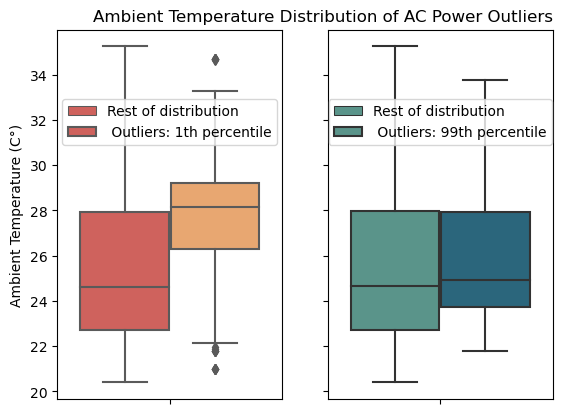

In [24]:
df_gen_weather['YEAR'] = df_gen_weather.DATE_TIME.dt.year
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
sns.boxplot(data=df_gen_weather, y='AMBIENT_TEMPERATURE', x='YEAR', hue='OUTLIER_HIGH_BOOL', ax=ax1);
sns.boxplot(data=df_gen_weather, y='AMBIENT_TEMPERATURE', x='YEAR', hue='OUTLIER_LOW_BOOL', ax=ax2, palette='crest');
plt.title('Ambient Temperature Distribution of AC Power Outliers', loc='right')
ax1.set_ylabel("Ambient Temperature (C\N{DEGREE SIGN})")
ax2.set_ylabel("")
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax1.set_xlabel("")
ax2.set_xlabel("")

ax1.legend(['Rest of distribution', ' Outliers: 1th percentile'], loc='center', bbox_to_anchor=(.5, .75));
ax2.legend(['Rest of distribution', ' Outliers: 99th percentile'], loc='center', bbox_to_anchor=(.5, .75));



These results do fit with what we would expect. The outliers with high power generation are on the high end of the ambiemt temperature distribution. And like we discovered earlier, the low power generation outliers, must have an explination other than the weather, since they are even above the mean of the ambient temp distribution. To quantify this some, we can perform a quick two-sample t-test.

For the 99th percentile outliers, we'll have a null hypothesis that the sample mean of the ambient temperature distribution across non-outliers is the same as sample mean of the ambient temperatures including the outliers; with the alternative hypothesis that the sample mean of the ambient temperature distribution across non-outliers is less than the sample mean of the ambient temperatures including the outliers. Let's have a typical threshold of 0.05.

In [25]:
from scipy import stats

stats, pval_high = stats.ttest_ind(np.array(df_gen_weather.query('OUTLIER_HIGH_BOOL == 0').AMBIENT_TEMPERATURE), np.array(df_gen_weather.query('OUTLIER_HIGH_BOOL == 1').AMBIENT_TEMPERATURE), alternative='less', equal_var=True, nan_policy='omit')
print("p-value for 99th percentile outliers: ", pval_high)

p-value for 99th percentile outliers:  2.412587253700915e-37


With a p-value well below our significance level, we can safely reject the null hypothesis in favor of the alternative hypothesis that the sample mean of the ambient temperature distribution across non-outliers is less than the sample mean of the ambient temperatures including the outliers.

For the 1th percentile outliers, we'll have a null hypothesis that the sample mean of the ambient temperature distribution across non-outliers is the same as sample mean of the ambient temperatures including the outliers; with the alternative hypothesis that the sample mean of the ambient temperature distribution across non-outliers is greater than the sample mean of the ambient temperatures including the outliers. Let's again have a threshold of 0.05.

<span style="font-family:Roboto Mono;font-stretch:normal;font-style:normal;font-weight:200;word-spacing:-.225em;">

In [26]:
from scipy import stats

stats, pval_low = stats.ttest_ind(np.array(df_gen_weather.query('OUTLIER_LOW_BOOL == 0').AMBIENT_TEMPERATURE), np.array(df_gen_weather.query('OUTLIER_LOW_BOOL == 1').AMBIENT_TEMPERATURE), alternative='greater', equal_var=True, nan_policy='omit')
print("p-value for 1th percentile outliers: ", np.round(pval_low, 4))

p-value for 1th percentile outliers:  0.8092


Now the p-value is clearly above our significance level, so we accept the null hypothesis that the sample mean of the ambient temperature distribution across non-outliers is the same as the sample mean of the ambient temperatures including the outliers. This lines up with our earlier speculation.

## Other outliers
Let's take a quick look at outliers in the other features, before moving to missing data. Since we'll be exploring several different features I will make a function to help streamline the process.

In [51]:
def outliers(df, feature, high_per, low_per, source_key=True):
    df = df.copy()
    df = df.merge(df.groupby('MINUTES_15').quantile(low_per, numeric_only=True)[feature].rename(f'OUTLIERS_LOW_{feature}'), on='MINUTES_15', how='left')
    df = df.merge(df.groupby('MINUTES_15').quantile(high_per, numeric_only=True)[feature].rename(f'OUTLIERS_HIGH_{feature}'), on='MINUTES_15', how='left')
    df = df.merge(df.groupby('MINUTES_15').mean(numeric_only=True)[feature].rename(f'MEAN_{feature}'), on='MINUTES_15', how='left')
    df = df.merge(df.groupby('MINUTES_15').std(numeric_only=True)[feature].rename(f'STD_{feature}'), on='MINUTES_15', how='left')
    df[f'STD_1_{feature}'] = df.query(f'{feature} < (MEAN_{feature} + STD_{feature}) and {feature} > (MEAN_{feature} - STD_{feature})')[feature]
    
    fig, ax = plt.subplots()
    sns.color_palette("Paired")
    if source_key == True:
        sns.scatterplot(data=df, y=feature, x='MINUTES_15', hue='SOURCE_KEY', palette='gray', alpha=0.05, legend=False)
        sns.scatterplot(data=df, y=f'STD_1_{feature}', x='MINUTES_15', hue='SOURCE_KEY', palette='gray', alpha =0.5, legend=False)
        sns.scatterplot(data=df.query(f'{feature} > OUTLIERS_HIGH_{feature}'), y=feature, x='MINUTES_15', hue='SOURCE_KEY', size=feature)
        sns.scatterplot(data=df.query(f'{feature} < OUTLIERS_LOW_{feature}'), y=feature, x='MINUTES_15', hue='SOURCE_KEY', size= -df[feature]) 
    else:
        sns.scatterplot(data=df, y=feature, x='MINUTES_15', color='gray', alpha=0.05, legend=False)
        sns.scatterplot(data=df, y=f'STD_1_{feature}', x='MINUTES_15', color='gray', alpha =0.5, legend=False)
        sns.scatterplot(data=df.query(f'{feature} > OUTLIERS_HIGH_{feature}'), color='blue', y=feature, x='MINUTES_15', size=feature)
        sns.scatterplot(data=df.query(f'{feature} < OUTLIERS_LOW_{feature}'), color='red', y=feature, x='MINUTES_15', size= -df[feature])
        
    plt.title(f'{feature} per 15 minutes')
    plt.ylabel(f'{feature}')
    plt.xlabel('Hour of Day')
    ax.set_xticks([i for i in range(1, 97, 4)])
    ax.set_xticklabels([i for i in range(24)])
    ax.legend(['Full data', '+/- 1\u03C3', 'Outliers']);
    return ax, df

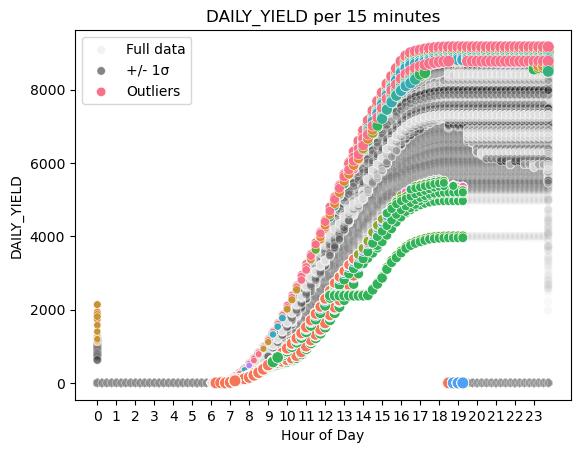

In [28]:
ax_daily_yield, df_daily_yield = outliers(df_gen, 'DAILY_YIELD', 0.95, 0.05)

There are some unusual things happening here. Mainly the 0s after 6pm. The straight line down at the end of the day and the other line at the start. These seem like they could well be incorrect data, or maybe some kind of correction of previous data. It is also interesting that they are not outliers for the most part, meaning this happens with some regularity. Whatever their exact cause, it is probably best to correct these to make the data less disconnected and ultimately help our model. We'll make the fix as part imputing missing values. 

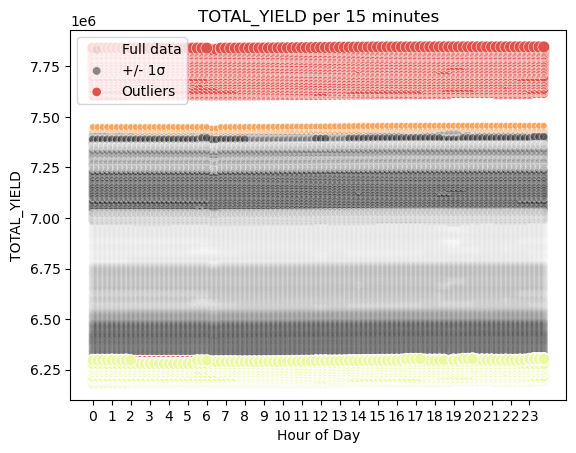

In [29]:
ax_total_yield, df_total_yield = outliers(df_gen, 'TOTAL_YIELD', 0.95, 0.05)

This just shows a spread of total yeild among the different sources. A sign that the sources are different ages and or operating at different capactities. 

In [30]:
df_gen.sort_values('TOTAL_YIELD').head()

,DATE_TIME,SOURCE_KEY,AC_POWER,DAILY_YIELD,TOTAL_YIELD,HOUR,DAY,DAY_WEEK,MINUTES_15,OUTLIERS_LOW_AC_POWER,OUTLIERS_HIGH_AC_POWER,MEAN,STD,STD_1
107,2020-05-15 01:15:00,Source_2,0.0,0.0,6183645.0,1,1,4,6,0.0,0.0,0.0,0.0,NaN
490,2020-05-15 05:45:00,Source_2,0.0,0.0,6183645.0,5,1,4,24,0.0,0.0,0.0,0.0,NaN
469,2020-05-15 05:30:00,Source_2,0.0,0.0,6183645.0,5,1,4,23,0.0,0.0,0.0,0.0,NaN
448,2020-05-15 05:15:00,Source_2,0.0,0.0,6183645.0,5,1,4,22,0.0,0.0,0.0,0.0,NaN
426,2020-05-15 05:00:00,Source_2,0.0,0.0,6183645.0,5,1,4,21,0.0,0.0,0.0,0.0,NaN


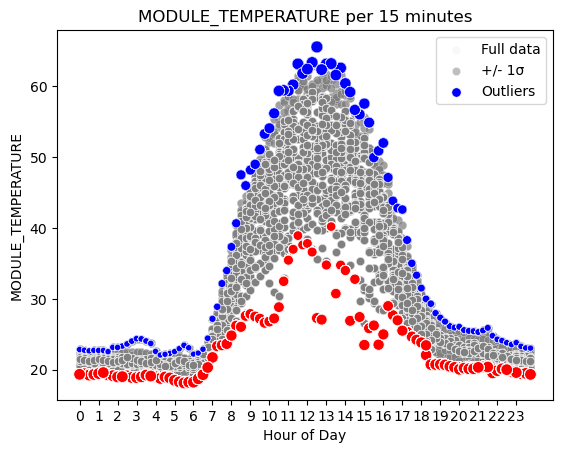

In [31]:
ax_module_temp, df_module_temp = outliers(df_gen_weather, 'MODULE_TEMPERATURE', 0.95, 0.05, source_key=False)

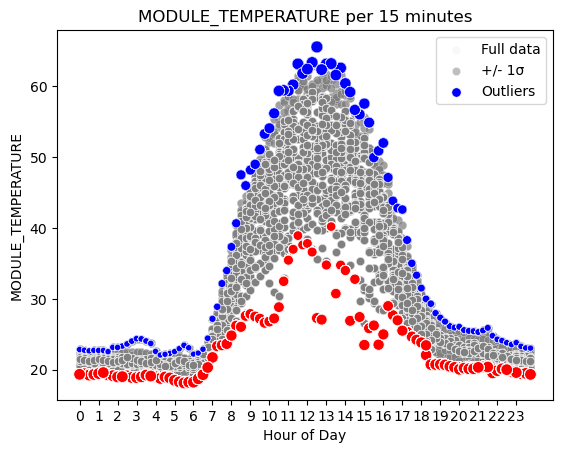

In [32]:
ax_module_temp, df_module_temp = outliers(df_gen_weather, 'MODULE_TEMPERATURE', 0.95, 0.05, source_key=False)

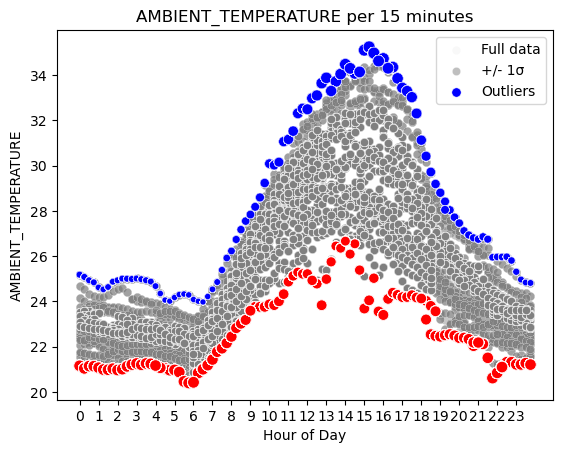

In [33]:
ax_ambient_temp, df_ambient_temp = outliers(df_gen_weather, 'AMBIENT_TEMPERATURE', 0.95, 0.05, source_key=False)

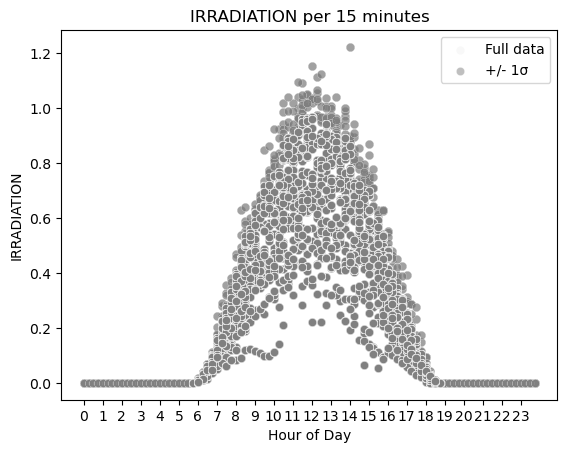

In [34]:
ax_irradiation, df_irradiation = outliers(df_gen_weather, 'IRRADIATION', 0.99, 0.01, source_key=False)

The temperature and irradiation data all show a pretty consistent distribution. There is one point irradiation point that seems a bit high, but it is still within 1 standard deviation.

<Axes: xlabel='IRRADIATION', ylabel='MODULE_TEMPERATURE'>

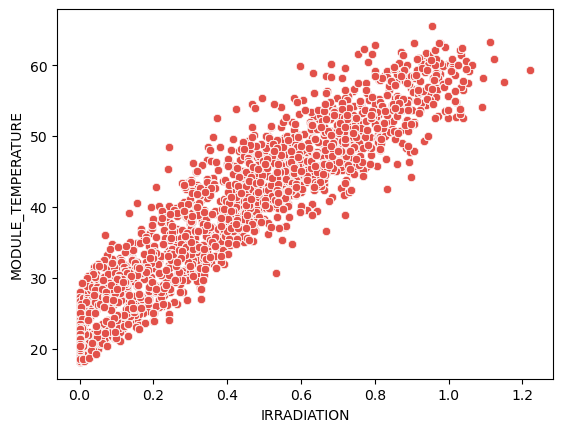

In [35]:
sns.scatterplot(data=df_gen_weather, y='MODULE_TEMPERATURE', x='IRRADIATION')

## Missing data

Next onto the data that seems to be missing. Let's focus in on the scatter plot that we noticed earlier and go back to our dataframe before the weather data was added as we will look for those missing values later.

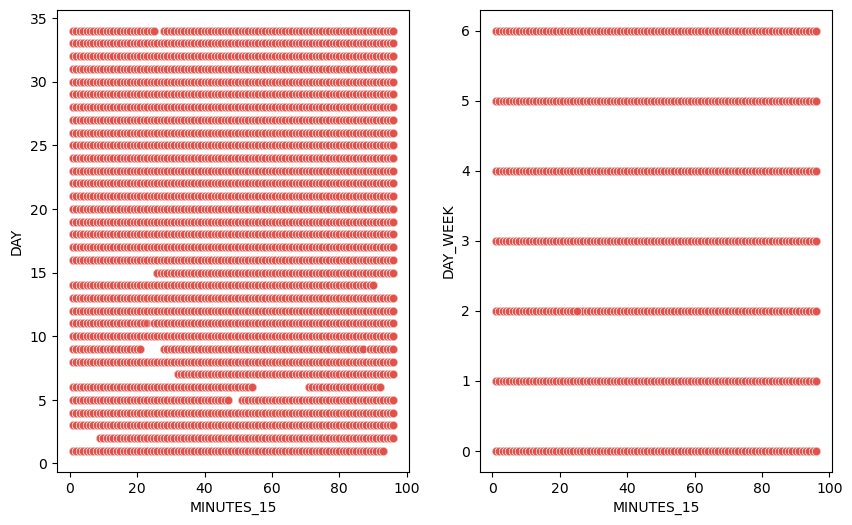

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 6))
sns.scatterplot(data=df_gen, y='DAY', x='MINUTES_15', legend=False, alpha=0.25, ax=ax1);
sns.scatterplot(data=df_gen, y='DAY_WEEK', x='MINUTES_15', legend=False, alpha=0.25, ax=ax2);

The gaps indicate the timestamps where data is missing accross the whole plant. They are concentrated around 2 days and don't seem to be related to day of week. Also, it looks like it is largly nighttime data, which is good. Let's check this the at source level.

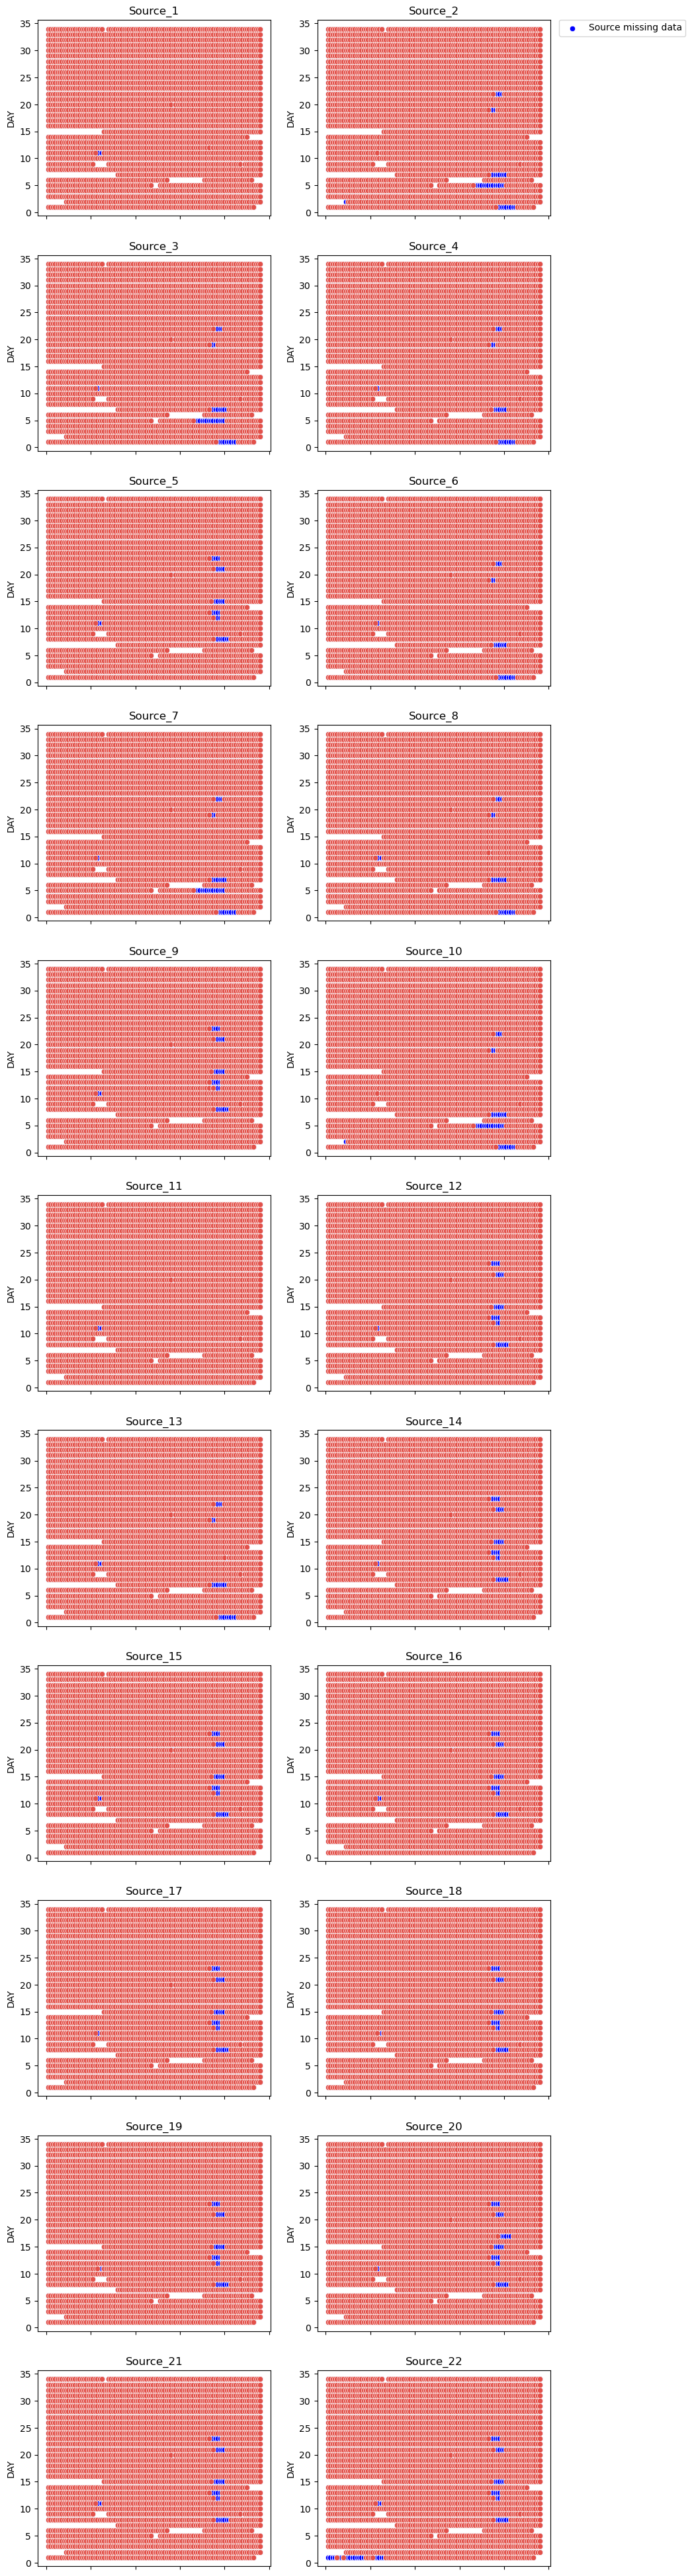

In [37]:
sources = df_gen.SOURCE_KEY.unique()
fig, axs = plt.subplots(11,2, figsize=(10, 50))
count = 0
for i in range(11):
    for j in range(2):
        sns.scatterplot(data=df_gen, y='DAY', x='MINUTES_15', color='blue', ax=axs[i][j])
        sns.scatterplot(data=df_gen[df_gen.SOURCE_KEY == sources[i+j+count]], y='DAY', x='MINUTES_15', legend=False, ax=axs[i][j])
        ax_current = axs[i][j]
        ax_current.set_title(sources[i+j+count])
        ax_current.set_xticklabels([])
        ax_current.set_xlabel("")
    count += 1   

plt.legend(['Source missing data'], bbox_to_anchor=(1.6, 13.025))
plt.show()

There is some additional data missing on almost all the sources, with some variation between. Again it is mostly at night. Now we'll quantify the results.

In [38]:
len(df_gen)

68778

With the 22 sources so we would expect there to be 34 (days) * 24 (hours) * 4 (15min in hour) * 22 (sources) = 71808 rows altogether. However, there are only 68777, so 3031 or ~4% of the total are missing. Let's see how many of these at night.

In [39]:
df_gen.query('HOUR < 6 or HOUR > 18').AC_POWER.sum() #output 0.0
df_gen.query('HOUR < 6 or HOUR > 18').HOUR.nunique() #output 11
len(df_gen.query('HOUR < 6 or HOUR > 18')) #output 30847
4 * 11 * 22 * 34 #output 32912
32912 - 30847

2065

About 2/3 or the missing data are during this time at night. Let's fine tune this a bit and look at the 15 minute intervals.

In [40]:
nighttime = df_gen[['AC_POWER', 'MINUTES_15']].groupby('MINUTES_15').sum().query('AC_POWER == 0').index
nighttime_length = len(nighttime)
nighttime_rows = len(df_gen[df_gen.MINUTES_15.isin(nighttime)])
expected_rows = nighttime_length * 22 * 34
expected_rows - nighttime_rows

2165

Fine tuning our search came up with 100 more of the missing rows at night. I think it will be worth imputing these with 0 for AC_POWER. Now we can move to the daytime ones.

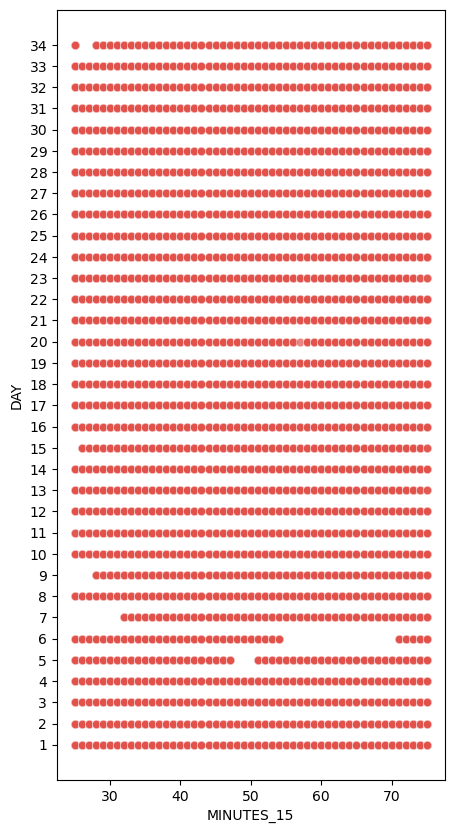

In [41]:
fig, ax = plt.subplots(figsize=(5,10))
sns.scatterplot(data=df_gen[~df_gen.MINUTES_15.isin(nighttime)], y='DAY', x='MINUTES_15', legend=False, alpha=0.25);
ax.set_yticks([i for i in range(1, 35)]);
ax.set_yticklabels([i for i in range(1, 35)]);

There looks like there is a concentration of missing data on the 6th day and also some on the 7th. The stretch missing on day 6 might be hard to impute, since it several hours in a row. We will try to use the interative imputer. We can then check this specific day to make sure it came up with a workable imputation.

Now we will check the weather data for missing datetimes.

In [42]:
df_weather = df_plt1_weather

df_weather = df_weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_weather['DATE_TIME'] = pd.to_datetime(df_weather.DATE_TIME, format='%Y-%m-%d %H:%M:%S') 
df_weather['HOUR'] = df_weather.DATE_TIME.dt.hour
df_weather['DAY'] = df_weather.DATE_TIME.dt.dayofyear
df_weather['DAY_WEEK'] = df_weather.DATE_TIME.dt.dayofweek
df_weather['MINUTES_15'] = df_weather.DATE_TIME.dt.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df_weather['MINUTES_15'] = df_weather.MINUTES_15.map({df_weather.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df_weather['DAY'] = df_weather.DAY.map({df_weather.DAY.unique()[i-1]:i for i in range(1, 35)})

<Axes: xlabel='MINUTES_15', ylabel='DAY'>

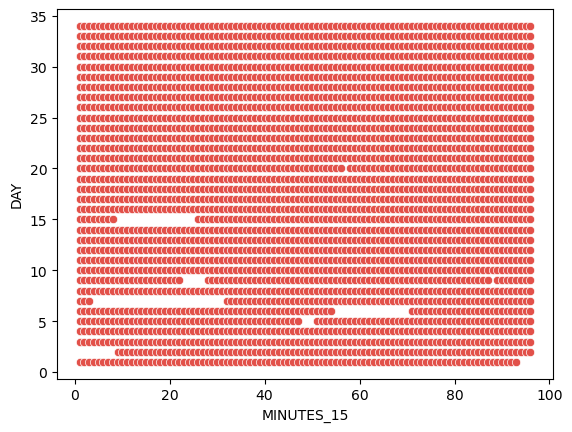

In [43]:
sns.scatterplot(data=df_weather, y='DAY', x='MINUTES_15')

The 6th and 7th day are again causing trouble. Maybe there was a power outage or some plant wide issue then. We will also try to impute the missing weather timestamps to fill in these gaps and hopefully help our model.

## Imputing missing values
To impute the data we will need to fill in our dataframe with the full datetime range we expect. This will give us the rows with missing values that we can then fill in.

In [44]:
datetime_full = pd.date_range(df_gen.DATE_TIME.min(), df_gen.DATE_TIME.max(), freq='15min')
#Making it a series to merge
datetime_full = pd.Series(datetime_full, name='DATE_TIME')
len(datetime_full) * len(sources) 

71808

This gives us our expected total. Now let's merge this with our generation and weather dataframes. In order to merge it with the generation data we will actually need to do it source by source, since different sources are missing different datetimes.

In [58]:
df_gen = df_plt1_gen
df_gen = df_plt1_gen.drop(['PLANT_ID', 'DC_POWER'], axis=1)
df_gen['SOURCE_KEY'] = df_gen.SOURCE_KEY.map({df_gen.SOURCE_KEY.unique()[i-1]: f'Source_{i}' for i in range(1, len(df_gen.SOURCE_KEY.unique()) +1)})
df_gen['DATE_TIME'] = pd.to_datetime(df_gen.DATE_TIME, format='%d-%m-%Y %H:%M')

source_dfs = []
for s in df_gen.SOURCE_KEY.unique():
    source_df = df_gen[df_gen.SOURCE_KEY == s].merge(datetime_full, on='DATE_TIME', how='right')
    source_dfs.append(source_df)
df_gen = pd.concat(source_dfs)


df_weather = df_plt1_weather
df_weather = df_weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
df_weather['DATE_TIME'] = pd.to_datetime(df_weather.DATE_TIME, format='%Y-%m-%d %H:%M:%S')
df_weather = df_weather.merge(datetime_full, on='DATE_TIME', how='right')
df_weather

df_gen = df_gen.merge(datetime_full, on='DATE_TIME', how='right')
df_weather = df_weather.merge(datetime_full, on='DATE_TIME', how='right')
#merging our filled out dfs together to make our main df
df = df_gen.merge(df_weather, on='DATE_TIME', how='left')


Let's remake our datatime features now that we have the full dataset.

In [59]:
df['HOUR'] = df.DATE_TIME.dt.hour
df['DAY'] = df.DATE_TIME.dt.dayofyear
df['DAY_WEEK'] = df.DATE_TIME.dt.dayofweek
df['MINUTES_15'] = df.DATE_TIME.dt.time

#This maps the 15 minute intervals over the course of the day to ints 1-96. 
df['MINUTES_15'] = df.MINUTES_15.map({df.MINUTES_15.unique()[i-1]:i for i in range(1, 97)})
#Change day of year to day of data
df['DAY'] = df.DAY.map({df.DAY.unique()[i-1]:i for i in range(1, 35)})

With a full datetime range from our dataframe we can now impute the missing values and clean up the previously discovered outliers. First, let's set all the night time values for AC_POWER generation to 0. 

In [60]:
df['AC_POWER'] = df['AC_POWER'].mask(df.MINUTES_15.isin(nighttime), 0)

correcting the disconnected daily yield values

In [61]:
df['DAILY_YIELD'] = df['DAILY_YIELD'].mask(df.HOUR.isin([0]), 0)

correcting end of day daily yield values by setting all after 6pm to the maximum of the day.

In [62]:
df = df.merge(df.groupby('DAY').max(numeric_only=True)['DAILY_YIELD'].rename('DAILY_YIELD_DAY_MAX'), on='DAY', how='left')
df['DAILY_YIELD'] = df['DAILY_YIELD'].mask(df.HOUR >= 18, df['DAILY_YIELD_DAY_MAX'])

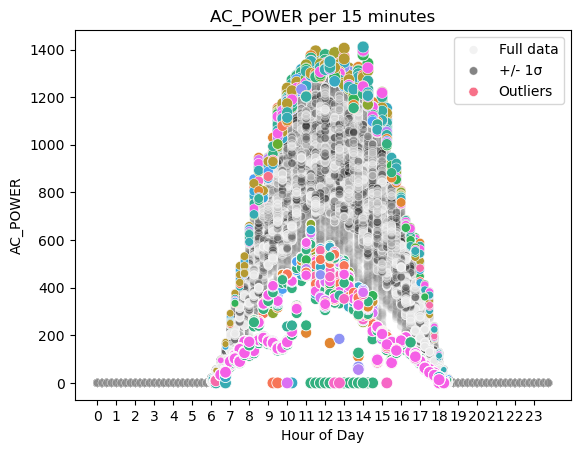

In [63]:
ax_daily_yield, df_daily_yield = outliers(df, 'AC_POWER', 0.95, 0.05)

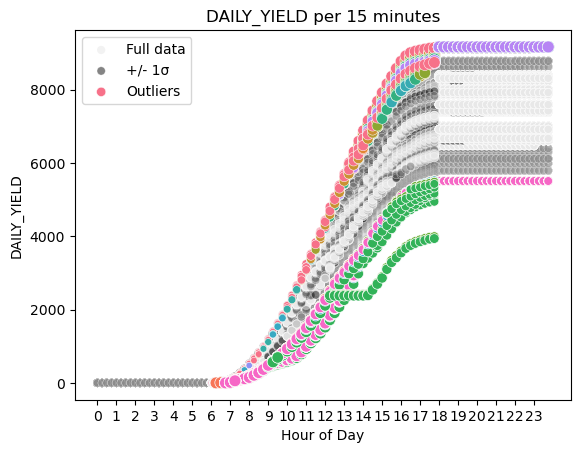

In [64]:
ax_daily_yield, df_daily_yield = outliers(df, 'DAILY_YIELD', 0.95, 0.05)

Now we are finally able to impute the missing data. Let's try the iterative imputer, which should give us good results for our time series data. We will again need to do this for each source seperately.

In [67]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

source_dfs = []
for s in df.SOURCE_KEY.unique():
    source_df = df[df.SOURCE_KEY == s]
    source_key = source_df.pop('SOURCE_KEY')
    source_df.index = source_df.pop('DATE_TIME')
    mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
    source_df = pd.DataFrame(mice_imputer.fit_transform(source_df), columns=source_df.columns)
    source_df['SOURCE_KEY'] = source_key
    source_df['DATE_TIME'] = source_df.index
    source_df = source_df.reset_index()
    source_dfs.append(source_df)
df = pd.concat(source_dfs)

ValueError: Found array with 0 sample(s) (shape=(0, 11)) while a minimum of 1 is required by IterativeImputer.